In [49]:
import json
import math
import random
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from copy import deepcopy
from itertools import chain
from transformers import get_linear_schedule_with_warmup
from torch import Tensor
from torch.optim import Adam
from torch.nn import Transformer
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from bert import BERT
from utils_vocab import BasicTokenizer, BERTDataset, evaluate

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [50]:
tokenizer_file = 'tokenizer_5.pkl'
# tokenizer_file = 'tokenizer_10.pkl'
# tokenizer_file = 'tokenizer_15.pkl'
# tokenizer_file = 'tokenizer_20.pkl'

path_dataset = 'bert_data_negacion_5.csv'
# path_dataset = 'bert_data_negacion_10.csv'
# path_dataset = 'bert_data_negacion_15.csv'
# path_dataset = 'bert_data_negacion_20.csv'

model_file = 'negacion_5.pt'
# model_file = 'negacion_10.pt'
# model_file = 'negacion_15.pt'
# model_file = 'negacion_20.pt'

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Crear el tokenizer

In [51]:
special_symbols = ['[UNK]', '[PAD]', '[CLS]', '[SEP]', '[MASK]']
simple_tokenizer = lambda tokens_string: tokens_string.strip().split()
tokenizer = BasicTokenizer.create_using_stoi(simple_tokenizer, special_symbols, tokenizer_file)
print('vocabulary_size:', tokenizer.get_vocab_size())

vocabulary_size: 41


### Split into training and test

In [52]:
df = pd.read_csv(path_dataset)
print(df.shape)

(10650, 4)


In [53]:
# Define features (X) and target (y)
X = df[['bert_input', 'segment_label']]  # Replace with your feature columns
y = df[['bert_label', 'relation']]  # Replace with your target column

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Output the shapes to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8520, 2)
X_test shape: (2130, 2)
y_train shape: (8520, 2)
y_test shape: (2130, 2)


In [54]:
df_train = pd.DataFrame({
    'BERT Input': X_train['bert_input'],
    'Segment Label': X_train['segment_label'],
    'BERT Label': y_train['bert_label'],
    'Is Next': y_train['relation']
})
df_train.head()

,BERT Input,Segment Label,BERT Label,Is Next
3031,"[2, 24, 15, 7, 22, 9, 3, 1, 5, 15, 23, 7, 4, 2...","[1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18, 1, 1, 1]",1
7959,"[2, 5, 13, 11, 21, 10, 3, 40, 4, 11, 21, 10, 3...","[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 13, 1, 1, 1, 1, 1]",0
8511,"[2, 5, 13, 18, 7, 21, 11, 3, 1, 24, 4, 18, 23,...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 31, 18, 1, 1, 1...",0
6843,"[2, 5, 14, 19, 10, 3, 40, 4, 19, 4, 3, 1]","[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0]","[1, 1, 1, 1, 1, 1, 1, 14, 1, 31, 1, 1]",0
4794,"[2, 24, 4, 19, 11, 4, 9, 3, 1, 5, 14, 19, 23, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, ...","[1, 1, 14, 1, 1, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1


In [55]:
df_test = pd.DataFrame({
    'BERT Input': X_test['bert_input'],
    'Segment Label': X_test['segment_label'],
    'BERT Label': y_test['bert_label'],
    'Is Next': y_test['relation']
})
df_test.head()

,BERT Input,Segment Label,BERT Label,Is Next
3860,"[2, 24, 14, 18, 4, 22, 10, 3, 1, 5, 14, 18, 4,...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, ...","[1, 1, 14, 1, 3, 1, 1, 1, 1, 1, 1, 1, 23, 1, 1...",1
6772,"[2, 5, 4, 4, 11, 3, 40, 4, 18, 11, 3, 1]","[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0]","[1, 1, 6, 2, 1, 1, 1, 6, 1, 1, 1, 1]",0
4299,"[2, 24, 15, 11, 21, 10, 3, 1, 5, 4, 23, 11, 22...","[1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 15, 1, 1, 1, 1, 1, 1]",1
8956,"[2, 5, 12, 20, 4, 22, 7, 3, 1, 4, 12, 20, 23, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 9, 1, 1, 1, 1, 24, 1, 1, 1, 1, 1,...",0
4626,"[2, 24, 13, 17, 8, 21, 10, 3, 1, 5, 13, 4, 23,...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, ...","[1, 1, 13, 1, 1, 1, 10, 1, 1, 1, 1, 17, 1, 1, ...",1


# Crear los dataloaders

In [56]:
PAD_IDX = 1

def collate_batch(batch):
    bert_inputs_batch, bert_labels_batch, segment_labels_batch, is_nexts_batch = [], [], [], []

    for bert_input, bert_label, segment_label, is_next in batch:
        # Convert each sequence to a tensor and append to the respective list
        bert_inputs_batch.append(torch.tensor(bert_input, dtype=torch.long))
        bert_labels_batch.append(torch.tensor(bert_label, dtype=torch.long))
        segment_labels_batch.append(torch.tensor(segment_label, dtype=torch.long))
        is_nexts_batch.append(is_next)

    # Pad the sequences in the batch
    bert_inputs_final = pad_sequence(bert_inputs_batch, padding_value=PAD_IDX, batch_first=False)
    bert_labels_final = pad_sequence(bert_labels_batch, padding_value=PAD_IDX, batch_first=False)
    segment_labels_final = pad_sequence(segment_labels_batch, padding_value=PAD_IDX, batch_first=False)
    is_nexts_batch = torch.tensor(is_nexts_batch, dtype=torch.long)

    return bert_inputs_final.to(device), bert_labels_final.to(device), segment_labels_final.to(device), is_nexts_batch.to(device)

In [57]:
BATCH_SIZE = 128

train_dataset = BERTDataset(df_train)
test_dataset = BERTDataset(df_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)


In [58]:
for bert_input, bert_label, segment_label, is_next in train_dataloader:
    print(f'{bert_input=}')
    print(f'{bert_label=}')
    print(f'{segment_label=}')
    print(f'{is_next=}')
    break

bert_input=tensor([[ 2,  2,  2,  ...,  2,  2,  2],
        [ 5,  5,  5,  ..., 24,  4,  5],
        [ 4, 13, 14,  ..., 14,  5, 13],
        ...,
        [ 1, 23,  3,  ...,  1,  1,  3],
        [ 1,  4,  1,  ...,  1,  1,  1],
        [ 1,  3,  1,  ...,  1,  1,  1]], device='mps:0')
bert_label=tensor([[ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1, 23,  1],
        [14,  1,  1,  ..., 14,  1,  1],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1, 25,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]], device='mps:0')
segment_label=tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 2, 2,  ..., 1, 1, 2],
        [1, 2, 1,  ..., 1, 1, 1],
        [1, 2, 1,  ..., 1, 1, 1]], device='mps:0')
is_next=tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0,

In [59]:
for bert_input, bert_label, segment_label, is_next in test_dataloader:
    print(f'{bert_input=}')
    print(f'{bert_label=}')
    print(f'{segment_label=}')
    print(f'{is_next=}')
    break

bert_input=tensor([[ 2,  2,  2,  ...,  2,  2,  2],
        [24,  5, 24,  ...,  5, 24,  5],
        [14,  4, 15,  ..., 15,  4, 12],
        ...,
        [23,  1,  3,  ..., 23,  1,  1],
        [10,  1,  1,  ..., 11,  1,  1],
        [ 3,  1,  1,  ...,  3,  1,  1]], device='mps:0')
bert_label=tensor([[ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [14,  6,  1,  ..., 15, 14,  1],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]], device='mps:0')
segment_label=tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [2, 1, 2,  ..., 2, 1, 1],
        [2, 1, 1,  ..., 2, 1, 1],
        [2, 1, 1,  ..., 2, 1, 1]], device='mps:0')
is_next=tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 0,

# Crear el modelo

In [60]:
EMBEDDING_DIM = 16

# Define parameters
vocab_size = tokenizer.get_vocab_size()  # Replace VOCAB_SIZE with your vocabulary size
d_model = EMBEDDING_DIM  # Replace EMBEDDING_DIM with your embedding dimension
n_layers = 4  # Number of Transformer layers
initial_heads = 4
# Ensure the number of heads is a factor of the embedding dimension
heads = initial_heads - d_model % initial_heads

dropout = 0.1  # Dropout rate

# Create an instance of the BERT model
model = BERT(vocab_size, d_model, n_layers, heads, dropout)
model.to(device)

BERT(
  (bert_embedding): BERTEmbedding(
    (token_embedding): TokenEmbedding(
      (embedding): Embedding(41, 16)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (segment_embedding): Embedding(3, 16)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (linear1): Linear(in_features=16, out_features=32, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=32, out_features=16, bias=True)
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerE

In [61]:
loss_fn_mlm = nn.CrossEntropyLoss(ignore_index=PAD_IDX)# The loss function must ignore PAD tokens and only calculates loss for the masked tokens
loss_fn_nsp = nn.CrossEntropyLoss()

In [62]:
with torch.no_grad():
    next_sentence_prediction, masked_language = model(bert_input, segment_label)

In [63]:
next_sentence_prediction

tensor([[-1.2419e-01, -7.9210e-02],
        [ 1.8394e-01, -2.0736e-01],
        [ 6.4290e-02, -3.4668e-02],
        [-2.2613e-01,  1.9153e-01],
        [ 2.4988e-01,  2.5916e-02],
        [ 2.3087e-01, -1.1581e-01],
        [ 3.3691e-01,  4.5807e-01],
        [-1.7929e-01,  3.7043e-01],
        [ 3.7350e-01,  8.4337e-01],
        [-1.1231e-01, -2.9553e-02],
        [-1.5477e-02,  1.0145e-01],
        [-1.0209e-01,  3.5964e-01],
        [ 6.6762e-01,  5.6972e-01],
        [ 3.9413e-01,  3.3779e-01],
        [-6.2308e-02, -2.0055e-01],
        [-3.7208e-01, -2.8909e-01],
        [ 9.5406e-02, -5.2941e-02],
        [-2.2643e-02,  2.0973e-01],
        [-1.2188e-02,  5.1386e-01],
        [ 3.1988e-02, -9.9249e-02],
        [-1.2206e-01, -1.5748e-01],
        [-1.0922e-01,  3.6312e-01],
        [ 7.4450e-02,  3.7370e-01],
        [-5.9012e-02, -1.5171e-01],
        [ 4.4104e-02,  3.0763e-02],
        [-2.8842e-01, -6.8332e-02],
        [-3.7927e-01,  3.3209e-01],
        [ 2.0601e-03,  1.206

In [64]:
loss_fn_nsp(next_sentence_prediction, is_next.view(-1))

tensor(0.7254, device='mps:0')

In [65]:
loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_label.view(-1))

tensor(3.9115, device='mps:0')

In [66]:
evaluate(
    dataloader=train_dataloader,
    model=model,
    loss_fn_mlm=loss_fn_mlm,
    loss_fn_nsp=loss_fn_nsp,
    device=device
)

(4.6018301248550415, 0.33767605633802816, 0.3183959415388332)

In [67]:
# Define the optimizer
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))

# Training loop setup
num_epochs = 10
total_steps = num_epochs * len(train_dataloader)

# Define the number of warmup steps, e.g., 10% of total
warmup_steps = int(total_steps * 0.1)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

# Lists to store losses for plotting
train_losses = []
eval_losses = []
accurracies = []
f1s = []

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

        optimizer.zero_grad()
        next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

        next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts)
        mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

        loss = next_loss + mask_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()  # Update the learning rate

        #total_loss += loss.item()

        if torch.isnan(loss):

            raise Exception(f'{loss.item()=}---{next_sentence_prediction=}\n{masked_language=}\n{next_loss=}\n{mask_loss=}\n{total_loss=}\n {bert_inputs=}\n{bert_labels=}\n{segment_labels=}\n{is_nexts=}') 
        else:
            total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader) + 1
    assert(not np.isnan(avg_train_loss)), f'{loss.item()=}---{total_loss=}\n {bert_inputs=}\n{bert_labels=}\n{segment_labels=}\n{is_nexts=}'
    train_losses.append(avg_train_loss)
    #print(f"Epoch {epoch+1} - Average training loss: {avg_train_loss:.4f}")

    # Evaluation after each epoch
    eval_loss, acc, f1 = evaluate(test_dataloader, model, loss_fn_nsp, loss_fn_mlm, device)
    eval_losses.append(eval_loss)
    accurracies.append(acc)
    f1s.append(f1)


Training Epochs: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it]


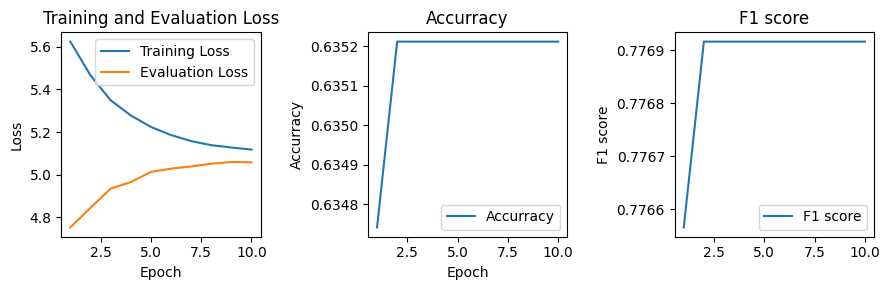

In [68]:
fig,axes = plt.subplots(
    1,3,
    figsize=(9,3),
    tight_layout=True
)
sns.lineplot(ax = axes[0], x=range(1, num_epochs + 1), y=train_losses, label='Training Loss')
sns.lineplot(ax = axes[0], x=range(1, num_epochs + 1), y=eval_losses, label='Evaluation Loss')
sns.lineplot(ax = axes[1], x=range(1, num_epochs + 1), y=accurracies, label='Accurracy')
sns.lineplot(ax = axes[2], x=range(1, num_epochs + 1), y=f1s, label='F1 score')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accurracy')
axes[2].set_ylabel('F1 score')
axes[0].set_title('Training and Evaluation Loss')
axes[1].set_title('Accurracy')
axes[2].set_title('F1 score')
plt.legend()
plt.show()

In [69]:
torch.save(model.state_dict(), model_file)

In [70]:
loss, acc, f1 = evaluate(
    dataloader=test_dataloader,
    model=model,
    loss_fn_mlm=loss_fn_mlm,
    loss_fn_nsp=loss_fn_nsp,
    device=device
)
print(f'Test loss: {loss}')
print(f'Test f1 score: {f1}')
print(f'Test accurracy: {acc}')

Test loss: 3.863619089126587
Test f1 score: 0.7769164513350559
Test accurracy: 0.6352112676056338


In [71]:
model.eval()

def predict_nsp(sentence1, sentence2, model, tokenizer):
    # Tokenize sentences with special tokens
    tokens1 = tokenizer.encode(sentence1).ids
    segment1 = torch.tensor([0]*len(tokens1))
    tokens1 = torch.tensor(tokens1, dtype=torch.long)
    tokens2 = tokenizer.encode(sentence1).ids
    segment2 = torch.tensor([1]*len(tokens2))
    tokens2 = torch.tensor(tokens2, dtype=torch.long)
    tokens_tensor = torch.cat([tokens1, tokens2]).to(device).unsqueeze(0)
    segment_tensor = torch.cat([segment1, segment2]).to(device).unsqueeze(0)

    # Predict
    with torch.no_grad():
        # Assuming the model returns NSP predictions first
        nsp_prediction, _ = model(tokens_tensor, segment_tensor)
        # Select the first element (first sequence) of the logits tensor
        first_logits = nsp_prediction[0].unsqueeze(0)  # Adds an extra dimension, making it [1, 2]
        logits = torch.softmax(first_logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()

    # Interpret the prediction
    return "Second sentence follows the first" if prediction == 1 else "Second sentence does not follow the first"

# Example usage
sentence1 = "no todo casa grande camina"
sentence2 = "algún casa grande no camina"

print(predict_nsp(sentence1, sentence2, model, tokenizer))

Second sentence follows the first


In [72]:
MASK_TOKEN = '[MASK]'
MASK_ID = 4

def predict_mlm(sentence, model, tokenizer):
    # Tokenize the input sentence and convert to token IDs, including special tokens
    inputs = tokenizer.encode(sentence).ids
    tokens_tensor = torch.tensor(inputs, dtype=torch.long).unsqueeze(0).to(device)

    # Create dummy segment labels filled with zeros, assuming it's needed by your model
    segment_labels = torch.zeros_like(tokens_tensor)

    with torch.no_grad():
        # Forward pass through the model, now correctly handling the output tuple
        output_tuple = model(tokens_tensor, segment_labels)

        # Assuming the second element of the tuple contains the MLM logits
        predictions = output_tuple[1]  # Adjusted based on your model's output

        # Identify the position of the [MASK] token
        mask_token_index = (tokens_tensor == MASK_ID).nonzero(as_tuple=True)[1]

        # Get the predicted index for the [MASK] token from the MLM logits
        predicted_index = torch.argmax(predictions[0, MASK_ID, :], dim=-1)
        predicted_token = tokenizer.decode([predicted_index.item()])[0]

        # Replace [MASK] in the original sentence with the predicted token
        predicted_sentence = sentence.replace(str(MASK_TOKEN), predicted_token, 1)

    return predicted_sentence


# Example usage
sentence = "algún casa grande no [MASK]"
print(predict_mlm(sentence, model, tokenizer))

algún casa grande no todo
